In [39]:
# Classes for dataset, network
# and several fuctions for data processing and trainnig

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
import os
from PIL import Image


# for test and validation, the transform only includes resize
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


# support gpu or not
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


# set seed for reproducibility
def same_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# a custom Dataset, load data from image
class FoodDataset(Dataset):
    # path: the path of folder where images are stored
    # tfm: the method used to transform image (for test or training)
    # files: the path of images
    def __init__(self, path, tfm=test_tfm, files=None):
        super().__init__()
        self.path = path
        self.transform = tfm

        if files != None:
            self.files = files
        # get the path of files in .jpg format
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])

    def __getitem__(self, index):
        fpath = self.files[index]  # the path of the indexed file
        im = Image.open(fpath)
        im = self.transform(im)  # do some transform to the image selected
        
        try:
            # get image's class from its name
            label = int(fpath.split("/")[-1].split("_")[0])
        except:
            label = -1  # test data has no label

        return im, label

    def __len__(self):
        # return the length of this dataset
        return len(self.files)


# build the CNN
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # Convolutional layers
        self.cnn = nn.Sequential(
            # the output get a same size with input by adding 1 padding
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),  # batch normalizatioin
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )

        # fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, input):
        cnn_out = self.cnn(input)
        # set the convolutional layer's output as a vector
        fc_input = cnn_out.view(cnn_out.size()[0], -1)
        return self.fc(fc_input)  # return the output of network
    
    def cal_loss(self, pred, target):
        self.criterion = nn.CrossEntropyLoss()  # set loss function to Cross Entropy
        return self.criterion(pred, target)


# this function includes everything for training
def train(tr_set, dv_set, model, config, device):
    num_epochs = config['num_epochs']  # number of epochs

    # set the optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    
    # init parameters for epochs
    max_acc = 0.  # set the initial value for min_mse (higher than the mse after first epoch)
    loss_record = {'train': [], 'val': []}
    acc_record = {'train': [], 'val': []}
    
    print("start training")
    # epochs for trianing
    for epoch in range(num_epochs):
        train_acc = 0
        train_loss = 0

        model.train()  # set model to trian mode
        for i, (data, label) in enumerate(tr_set):
            optimizer.zero_grad()  # set gradient to zero before calculate
            data, label = data.to(device), label.to(device)  # move data to device
            pred = model(data)  # compute the predict from data
            loss = model.cal_loss(pred, label)  # compute the mse loss
            _, train_pred = torch.max(pred, 1) # get the index of the class with the highest probability
            loss.backward()  # get the gradient
            # Clip the gradient norms for stable training
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()  # updata parameters in model

            train_loss += loss.item()
            train_acc += (train_pred.cpu() == label.cpu()).sum().item()

            # get loss as a tensor in cpu (item() cannot access tensor in cuda) 
            # without gradient computing requirement and trun it to a variant
            loss_record['train'].append(loss.detach().cpu().item())

            # print training status every 100 optimisations
            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(tr_set), loss.item()))

        # After each epoch, test your model on the validation (development) set.
        val_acc, val_loss = val(dv_set, model, device)

        train_acc = train_acc/len(tr_set.dataset)
        train_loss = train_loss/len(tr_set)

        acc_record['train'].append(train_acc)

        print('[{:03d}/{:03d}] Train ACC: {:3.6f} Loss: {:3.6f} | Val ACC: {:3.6f} loss: {:3.6f}'.format(epoch+1, num_epochs, train_acc, train_loss, val_acc, val_loss))

        if val_acc > max_acc:
            # Save model if your model improved
            max_acc = val_acc
            print('Saving model (epoch = {:4d}, acc = {:.4f})'
                .format(epoch + 1, max_acc))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['val'].append(val_loss)
        acc_record['val'].append(val_acc)

        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break
    
    print('Finished training after {} epochs'.format(epoch+1))
    return acc_record, loss_record, max_acc


# fuction to compute mse in validation
def val(dv_set, model, device):
    model.eval()  # set model to evalutation mode
    total_loss = 0
    val_acc = 0
    for x, y in dv_set:  # iterate through the dataloader
        x, y = x.to(device), y.to(device)  # move data to device (cpu/cuda)
        with torch.no_grad():  # disable gradient calculation
            pred = model(x)  # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss

        total_loss += mse_loss.detach().cpu().item()  # accumulate loss

        _, val_pred = torch.max(pred, 1)
        val_acc += (val_pred.cpu() == y.cpu()).sum().item() # get the index of the class with the highest probability

    return val_acc/len(dv_set.dataset), total_loss / len(dv_set)


# function for model test
def test(tt_set, model, device):
    model.eval()  # set model to evalutation mode
    preds = []

    for data,_ in tt_set:
        data = data.to(device)
        # we don't need compute gradient when testing
        with torch.no_grad():
            pred = model(data).to(device)
            _, test_pred = torch.max(pred, 1) # get the index of the class with the highest probability
            # dataloader process the dataset as batch
            for y in test_pred.cpu().numpy():
                preds.append(y)
    return preds


# function to plot learning curve
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

In [11]:
from torch.utils.data import DataLoader
import numpy as np
import gc

myseed = 6666  # set a random seed for reproducibility
same_seeds(myseed)

device = get_device()
print('your device: {}'.format(device))

# parameters for training
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'optimizer': 'Adam',  # optimizer algorithm
    'optim_hparas': {
        'lr': 0.0003, # learning rate
        'weight_decay': 1e-5
    },
    'save_path': 'model.pth',
    'early_stop': 5
}

your device: cuda


In [12]:
# load data
train_set = FoodDataset("/kaggle/input/ml2023spring-hw3/train", tfm=train_tfm)
val_set = FoodDataset("/kaggle/input/ml2023spring-hw3/valid", tfm=test_tfm)

train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_set, batch_size=config['batch_size'], shuffle=False)

# delete the data loaded to save space
del train_set, val_set
gc.collect()

165

In [16]:
model = Classifier().to(device)  # create network

acc_record, loss_record, max_acc = train(train_loader, val_loader, model, config, device)

start training
Epoch [1/10], Step [10/157], Loss: 2.1632
Epoch [1/10], Step [20/157], Loss: 2.0440
Epoch [1/10], Step [30/157], Loss: 2.1753
Epoch [1/10], Step [40/157], Loss: 1.9090
Epoch [1/10], Step [50/157], Loss: 1.9969
Epoch [1/10], Step [60/157], Loss: 1.8103
Epoch [1/10], Step [70/157], Loss: 1.8246
Epoch [1/10], Step [80/157], Loss: 1.7929
Epoch [1/10], Step [90/157], Loss: 1.6518
Epoch [1/10], Step [100/157], Loss: 1.9954
Epoch [1/10], Step [110/157], Loss: 1.7742
Epoch [1/10], Step [120/157], Loss: 1.8850
Epoch [1/10], Step [130/157], Loss: 1.7418
Epoch [1/10], Step [140/157], Loss: 1.8538
Epoch [1/10], Step [150/157], Loss: 1.7880
[001/010] Train ACC: 0.324600 Loss: 1.913906 | Val ACC: 0.345045 loss: 1.891498
Saving model (epoch =    1, acc = 0.3450)
Epoch [2/10], Step [10/157], Loss: 1.6436
Epoch [2/10], Step [20/157], Loss: 1.7831
Epoch [2/10], Step [30/157], Loss: 1.6873
Epoch [2/10], Step [40/157], Loss: 1.6921
Epoch [2/10], Step [50/157], Loss: 1.8701
Epoch [2/10], Ste

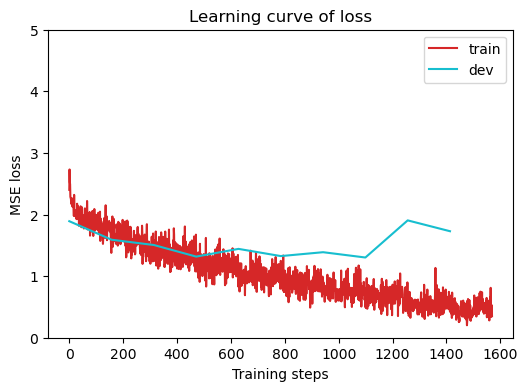

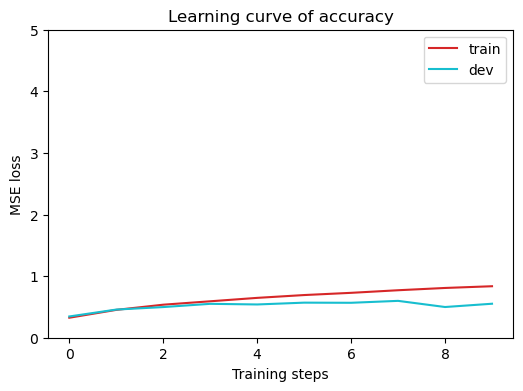

In [17]:
plot_learning_curve(loss_record, title='loss')
plot_learning_curve(acc_record, title='accuracy')

In [41]:
# data fot test
test_set = FoodDataset("/kaggle/input/ml2023spring-hw3/test", tfm=test_tfm)

test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)
#print(len(test_loader.dataset))

predicts = test(test_loader, model, device)

# save prediction for test dataset as a .csv file
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predicts):
        f.write('{},{}\n'.format(i, y))

In [45]:
import pandas as pd
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = predicts
df.to_csv("submission.csv",index = False)

In [46]:
!ls

__notebook_source__.ipynb  model.pth  prediction.csv  submission.csv
